In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 13314, 'height': 6081, 'count': 1, 'crs': CRS.from_wkt('PROJCS["World_Eckert_IV",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Eckert_IV"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(2541.8487998980077, 0.0, -16921197.840541057,
       0.0, -2541.8678915901482, 8460601.461471582), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


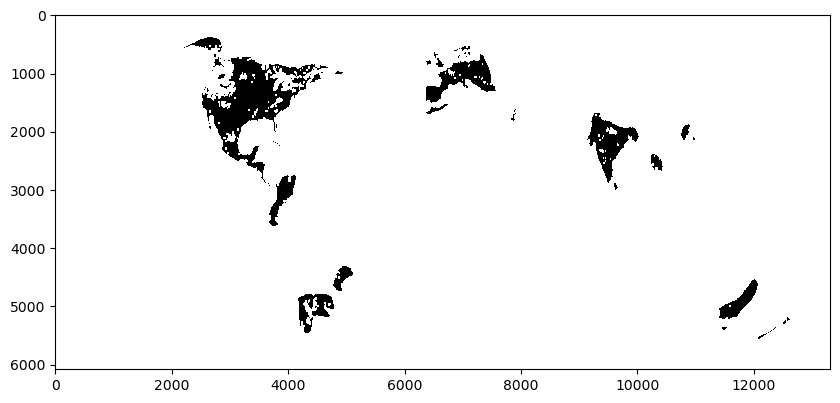

In [4]:
file_path = "amerob/amerob_abundance_median_2022-01-04.tif"
with rasterio.open(file_path) as dataset:
    print(dataset.profile)

    data = dataset.read(1)

    plt.figure(figsize=(10, 10))
    show(data, cmap='gray')
    plt.show()


width of 13,314 pixels and a height of 6,081 pixels.

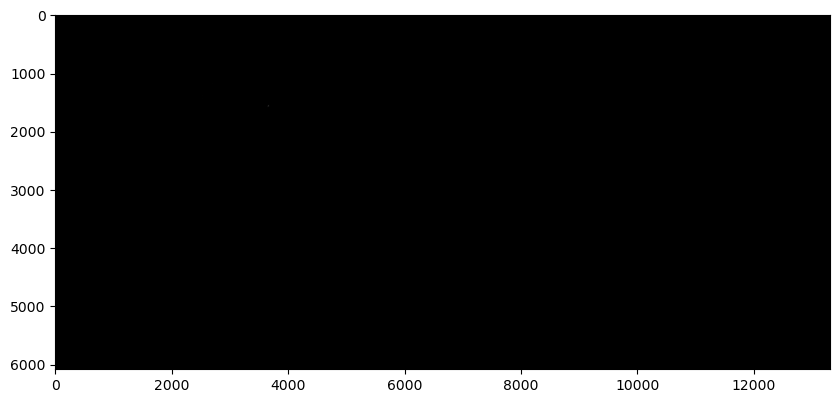

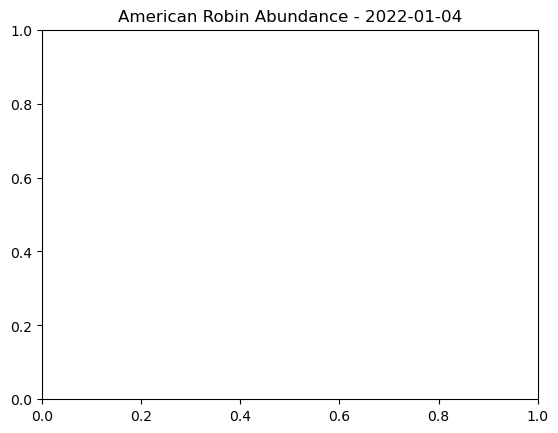

In [7]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Define the desired CRS (e.g., WGS 84)
dst_crs = 'EPSG:4326'

# Open the source dataset
with rasterio.open(file_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Output file path
    output_path = "/mnt/data/reprojected.tif"

    # Reproject and save the output
    with rasterio.open(output_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
